In [10]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

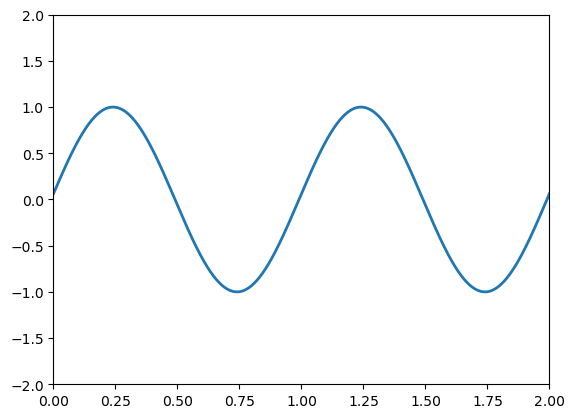

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('/Users/MiladM-Dev/Documents/1PhD/project-sim-ai/beast-simulation/Scripts/basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

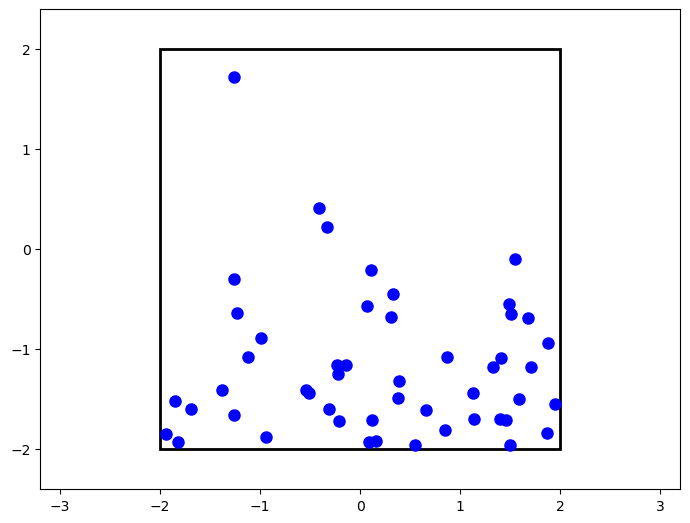

In [12]:
"""
Animation of Elastic collisions with Gravity

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""


class ParticleBox:
    """Orbits class
    
    init_state is an [N x 4] array, where N is the number of particles:
       [[x1, y1, vx1, vy1],
        [x2, y2, vx2, vy2],
        ...               ]

    bounds is the size of the box: [xmin, xmax, ymin, ymax]
    """
    def __init__(self,
                 init_state = [[1, 0, 0, -1],
                               [-0.5, 0.5, 0.5, 0.5],
                               [-0.5, -0.5, -0.5, 0.5]],
                 bounds = [-2, 2, -2, 2],
                 size = 0.04,
                 M = 0.05,
                 G = 9.8):
        self.init_state = np.asarray(init_state, dtype=float)
        self.M = M * np.ones(self.init_state.shape[0])
        self.size = size
        self.state = self.init_state.copy()
        self.time_elapsed = 0
        self.bounds = bounds
        self.G = G

    def step(self, dt):
        """step once by dt seconds"""
        self.time_elapsed += dt
        
        # update positions
        self.state[:, :2] += dt * self.state[:, 2:]

        # find pairs of particles undergoing a collision
        D = squareform(pdist(self.state[:, :2]))
        ind1, ind2 = np.where(D < 2 * self.size)
        unique = (ind1 < ind2)
        ind1 = ind1[unique]
        ind2 = ind2[unique]

        # update velocities of colliding pairs
        for i1, i2 in zip(ind1, ind2):
            # mass
            m1 = self.M[i1]
            m2 = self.M[i2]

            # location vector
            r1 = self.state[i1, :2]
            r2 = self.state[i2, :2]

            # velocity vector
            v1 = self.state[i1, 2:]
            v2 = self.state[i2, 2:]

            # relative location & velocity vectors
            r_rel = r1 - r2
            v_rel = v1 - v2

            # momentum vector of the center of mass
            v_cm = (m1 * v1 + m2 * v2) / (m1 + m2)

            # collisions of spheres reflect v_rel over r_rel
            rr_rel = np.dot(r_rel, r_rel)
            vr_rel = np.dot(v_rel, r_rel)
            v_rel = 2 * r_rel * vr_rel / rr_rel - v_rel

            # assign new velocities
            self.state[i1, 2:] = v_cm + v_rel * m2 / (m1 + m2)
            self.state[i2, 2:] = v_cm - v_rel * m1 / (m1 + m2) 

        # check for crossing boundary
        crossed_x1 = (self.state[:, 0] < self.bounds[0] + self.size)
        crossed_x2 = (self.state[:, 0] > self.bounds[1] - self.size)
        crossed_y1 = (self.state[:, 1] < self.bounds[2] + self.size)
        crossed_y2 = (self.state[:, 1] > self.bounds[3] - self.size)

        self.state[crossed_x1, 0] = self.bounds[0] + self.size
        self.state[crossed_x2, 0] = self.bounds[1] - self.size

        self.state[crossed_y1, 1] = self.bounds[2] + self.size
        self.state[crossed_y2, 1] = self.bounds[3] - self.size

        self.state[crossed_x1 | crossed_x2, 2] *= -1
        self.state[crossed_y1 | crossed_y2, 3] *= -1

        # add gravity
        self.state[:, 3] -= self.M * self.G * dt


#------------------------------------------------------------
# set up initial state
np.random.seed(0)
init_state = -0.5 + np.random.random((50, 4))
init_state[:, :2] *= 3.9

box = ParticleBox(init_state, size=0.04)
dt = 1. / 30 # 30fps


#------------------------------------------------------------
# set up figure and animation
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-3.2, 3.2), ylim=(-2.4, 2.4))

# particles holds the locations of the particles
particles, = ax.plot([], [], 'bo', ms=6)

# rect is the box edge
rect = plt.Rectangle(box.bounds[::2],
                     box.bounds[1] - box.bounds[0],
                     box.bounds[3] - box.bounds[2],
                     ec='none', lw=2, fc='none')
ax.add_patch(rect)

def init():
    """initialize animation"""
    global box, rect
    particles.set_data([], [])
    rect.set_edgecolor('none')
    return particles, rect

def animate(i):
    """perform animation step"""
    global box, rect, dt, ax, fig
    box.step(dt)

    ms = int(fig.dpi * 2 * box.size * fig.get_figwidth()
             / np.diff(ax.get_xbound())[0])
    
    # update pieces of the animation
    rect.set_edgecolor('k')
    particles.set_data(box.state[:, 0], box.state[:, 1])
    particles.set_markersize(ms)
    return particles, rect

ani = animation.FuncAnimation(fig, animate, frames=600,
                              interval=10, blit=True, init_func=init)


# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
ani.save('/Users/MiladM-Dev/Documents/1PhD/project-sim-ai/beast-simulation/Scripts/particle_box.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()